In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

# Word distribution

As We know, frequency of unique words in a text corpus follows a Power Law. As we take only the 3000 + words each year, this means that we do not capture the entire word distribution.

In [62]:
wordYear = pd.read_csv('Data/3kPluswordPerYear.csv',index_col=0)
wordYear.head()

,-a,-la,-le,-on,-—,aarau,aarberg,aarbourg,aarg,aarhus,...,œil,œillet,œquo,œrlikon,œuf,œur-,œuvre,——,———,„„„
1798-01-01,0.0,0.0,8.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0
1799-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
1804-01-01,0.0,0.0,14.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,0.0,0.0,0.0,2.0,0.0,18.0,5.0,0.0,0.0
1805-01-01,0.0,4.0,9.0,4.0,0.0,0.0,8.0,0.0,0.0,0.0,...,6.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,4.0
1806-01-01,3.0,0.0,12.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0


In [63]:
minValues = wordYear[wordYear>0].loc[wordYear.index[160]].sort_values(ascending=False).dropna().values

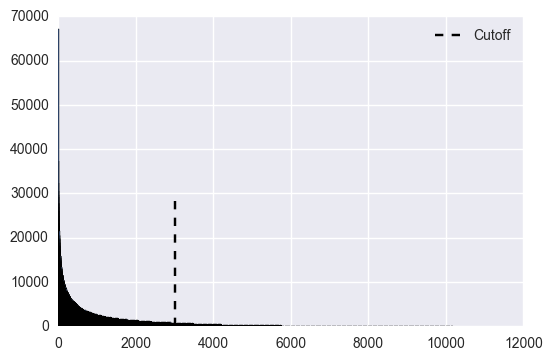

In [118]:
plt.bar(np.arange(0,len(minValues)),minValues)
plt.plot((3000, 3000), (0, 30000), 'k--',label='Cutoff')
plt.legend()

As we can see on the graph, the cutoff limit misses a small part of the distribution. What we would like to understand is how much of the data we missed, in terms of percentage.

To be able to compute the percentage we will look at the distribution in a log-in graph.

(0, 11)

/Users/thomas/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


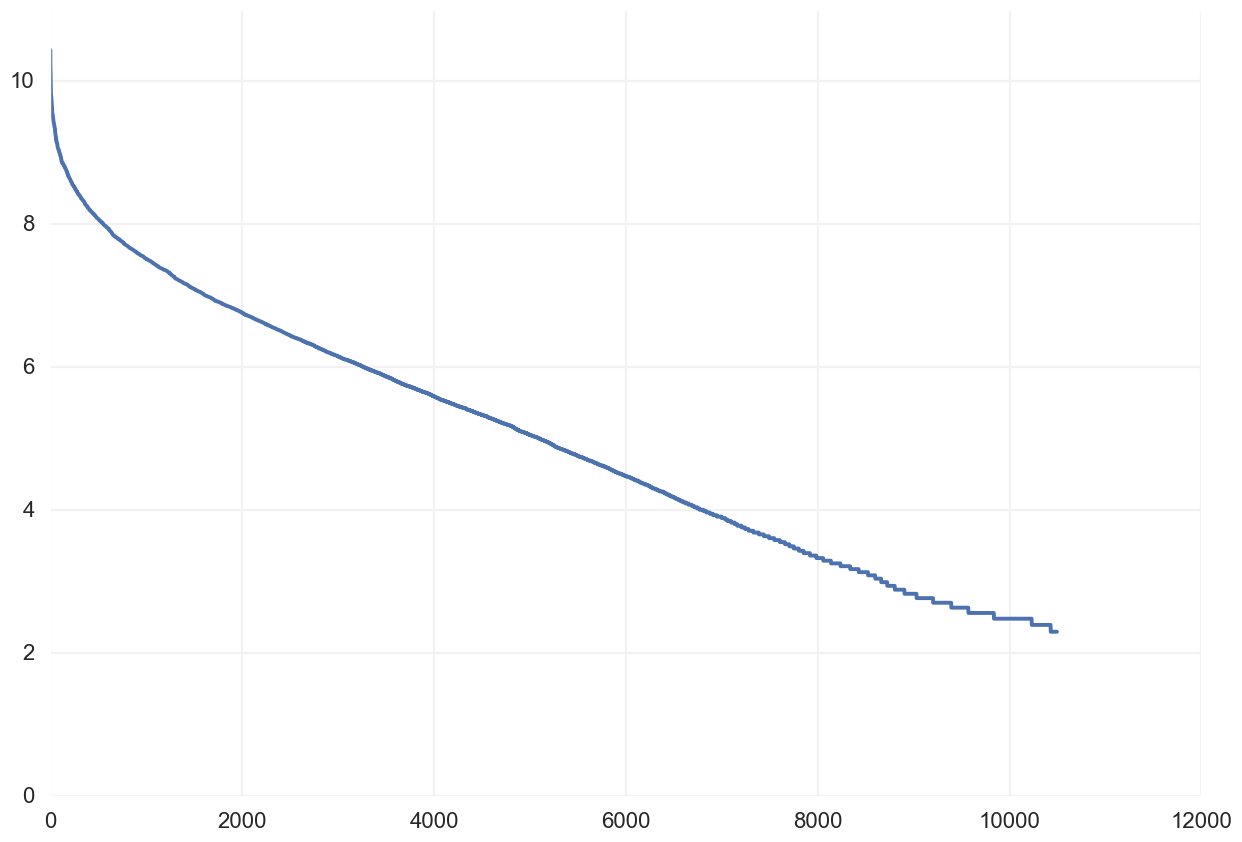

In [64]:
logMinValues = np.log(minValues)
plt.plot(logMinValues)
plt.ylim([0,11])

We can see that in the log scale, we see that the distribution becomes linear, we also see the part that we miss. What We propose to implement a linear regression on the center part of the data to approximate the whole distribution. we also see that the slope dicreases near the end of the distribution, therefore we will fit the end of it to loose a smaller amout of information

/Users/thomas/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


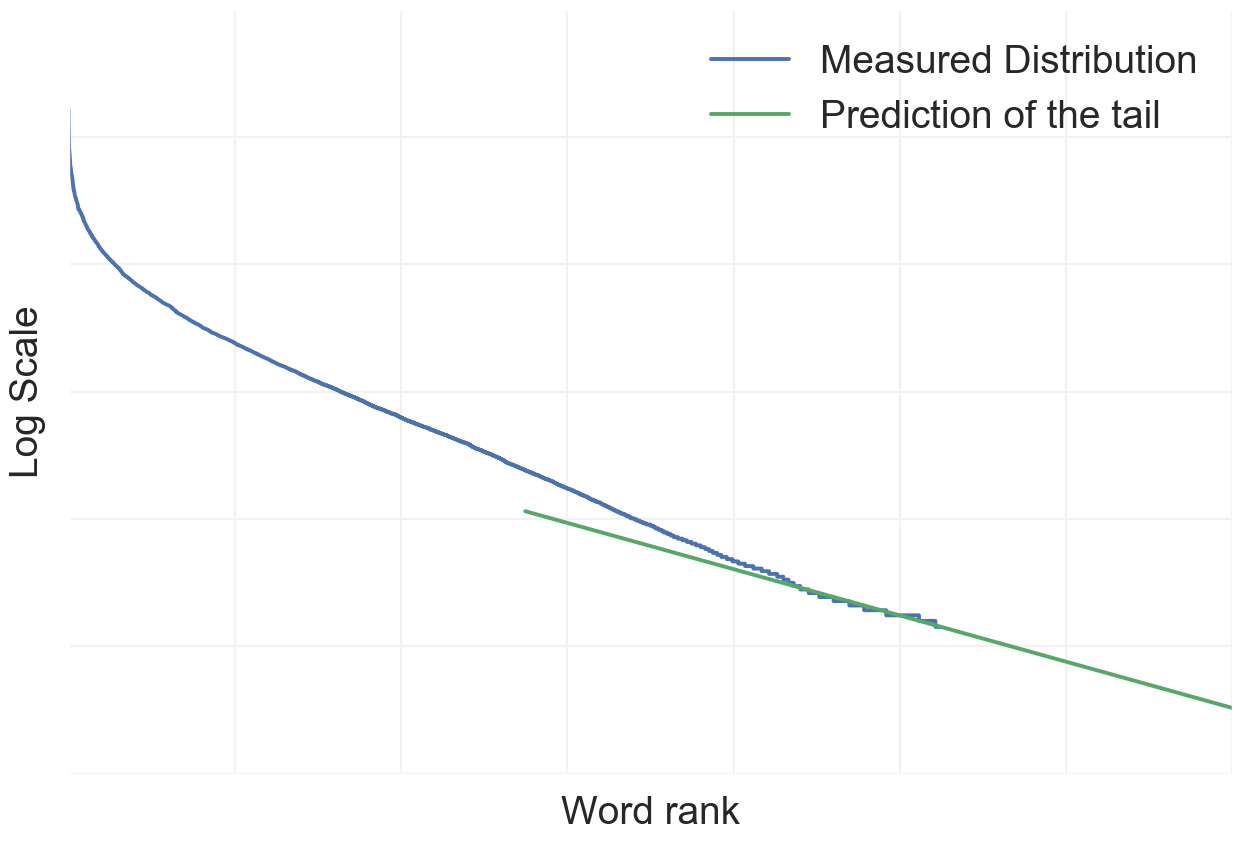

In [74]:
x = np.arange(0,len(minValues))[-2000:]
x_tot = np.arange(0,len(minValues)+3500)
fit = np.polyfit(x,logMinValues[-2000:],deg=1)
plt.plot(logMinValues,label='Measured Distribution')
plt.plot(x_tot[-8500:],(fit[0]*x_tot + fit[1])[-8500:],label='Prediction of the tail')
plt.ylabel('Log Scale',fontsize=28)
plt.xlabel('Word rank',fontsize=28)
ax1 = plt.gca()
sns.set_style("whitegrid",{'grid.color': '0.95','grid.linewidth': 0.01})
sns.set_context("poster")
ax1.set_yticklabels([])
ax1.set_xticklabels([])
plt.legend(loc=1,prop={'size':28})
plt.rc('axes',edgecolor='white')
plt.savefig('Plots/LogScale.png')

We see that with a rough linear fit we are able to do a nice approximation of the distribution at the end.

Now we can find the abscissa using the equation of the linear curve that we fitted.

$$y = ax + b$$

$$ 0 = ax + b$$

$$ x = \frac{-b}{a}$$

In [131]:
abcissa  = np.round(-fit[1]/fit[0])

Now that we have this information we can bring back the distribution to linear scale, and complete the rest of the distribution that we missed. We then compute the percentage of the distribution that is under the predicted portion of the distribution.

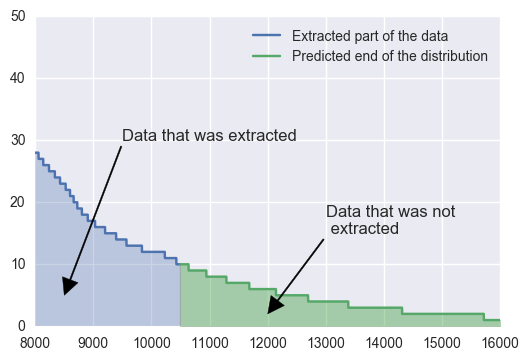

In [132]:
predictedDistr = np.arange(len(minValues),abcissa)
logPredict = predictedDistr*fit[0] + fit[1]
predCount = np.round(np.power(np.e,logPredict))
plt.plot(minValues,label='Extracted part of the data')
plt.fill_between(np.arange(0,len(minValues)),minValues,np.zeros(len(minValues)),alpha=0.3)
plt.plot(predictedDistr,predCount,label='Predicted end of the distribution')
plt.fill_between(predictedDistr,predCount,facecolor='green',alpha=0.3)
plt.annotate('Data that was extracted', xy=(8500, 5), xytext=(9500, 30),
            arrowprops=dict(facecolor='black', shrink=1,width=1),fontsize=12
            )
plt.annotate('Data that was not\n extracted', xy=(12000, 2), xytext=(13000, 15),
            arrowprops=dict(facecolor='black', shrink=1,width=1),fontsize=12
            )
plt.xlim([8000,16000])
plt.ylim([0,50])
plt.legend()

Now we can compute the area between each curve, the percentage that we miss is the following equation:

$$ Percentage = 1 - \frac{WordsExtracted}{WordsExtracted + WordsNotExtracted}$$

And we can compute that by integrating under each curve.

In [133]:
print('Percentage of distribution that was missed: ',
      (1-np.sum(minValues)/((np.sum(minValues)+np.sum(predCount))))*100,' %')

Percentage of distribution that was missed:  0.347955983991  %


Now we can implement that for each year and store the data.

In [116]:
yearIndex = wordYear.index
missingPart = []
minWordYear = []
for i in yearIndex:
    minValues = wordYear[wordYear>0].loc[i].sort_values(ascending=False).dropna().values
    minWordYear.append(minValues[-1])
    logMinValues = np.log(minValues)
    x = np.arange(0,len(minValues))[-2000:]
    x_tot = np.arange(0,len(minValues)+3500)
    fit = np.polyfit(x,logMinValues[-2000:],deg=1)
    abcissa  = np.round(-fit[1]/fit[0])
    if abcissa > 50000:
        abcissa = 50000
    predictedDistr = np.arange(len(minValues),abcissa)
    logPredict = predictedDistr*fit[0] + fit[1]
    predCount = np.round(np.power(np.e,logPredict))
    missingPart.append((1-np.sum(minValues)/((np.sum(minValues)+np.sum(predCount))))*100)

/Users/thomas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


And now we want to save the data and then view it.

In [120]:
s1 = pd.Series(yearIndex)
s2 = pd.Series(missingPart)
s3 = pd.Series(minWordYear)
df = pd.concat([s1,s2,s3],axis=1)
df.columns = ['Date','Percentage Missing','Minimum Number of Words']
df.head()
df.to_csv('Data/minNumWordsYear.csv')

And now we can visualize it!

In [27]:
df2 =pd.read_csv('Data/minNumWordsYear.csv',index_col=0)
df2['Date'] = df2['Date'].map(lambda x: x[:4])
df = df2.loc[np.arange(0,len(df2))]
df['Date'].astype(int,inplace=True)
df.head()

,Date,Percentage Missing,Minimum Number of Words
0,1798,0.168738,1.0
1,1799,0.472447,2.0
2,1804,0.260857,1.0
3,1805,0.921525,2.0
4,1806,0.912688,2.0


We also want to create an index so that we don't have an x axis that is too cluttered.

In [54]:
hidetick =  np.array(['    ']*len(df),dtype=str)
hidetick[np.arange(5,len(df),20)] = df['Date'].astype(str).values[np.arange(0,len(df),10)]

/Users/thomas/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
  from ipykernel import kernelapp as app


/Users/thomas/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


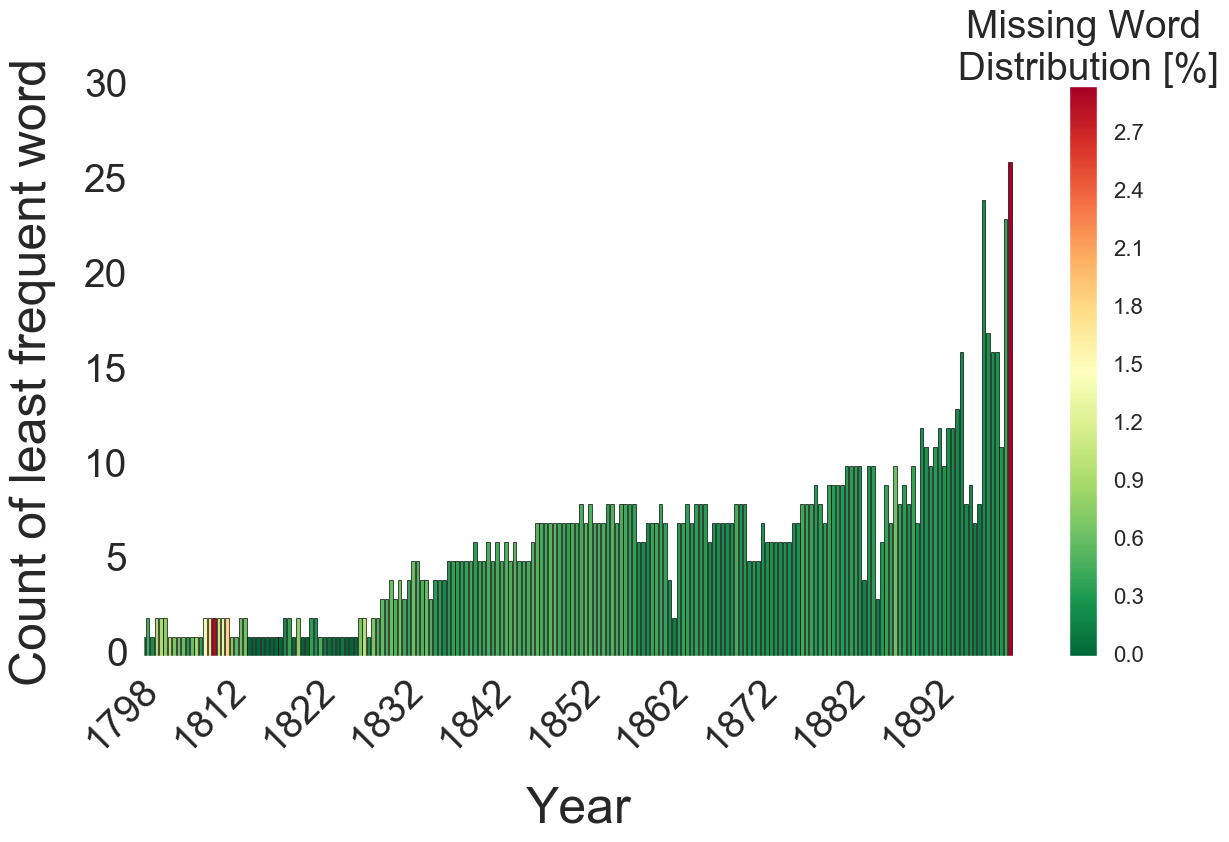

In [60]:
from matplotlib import cm

f,ax1 = plt.subplots()

sns.set_style("whitegrid",{'grid.color': '0.95','grid.linewidth': 0.01})
sns.set_context("poster")

plt.rc('axes',edgecolor='white')
csfont = {'fontname':'Arial'}

# Set up colors : red to green
y = np.array(df['Percentage Missing'])
colors = cm.RdYlGn_r(y / float(max(y)))
plot = ax1.scatter(y, y, c=y, cmap = 'RdYlGn_r')
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Missing Word\n Distribution [%]",fontsize=28,**csfont)

# Display bar plot : country frequency vs. country name, with color indicating polarity score
plt.bar(range(df.shape[0]), df['Minimum Number of Words'],tick_label=hidetick, align='center', color=colors)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Year",fontsize=36,labelpad=20,**csfont)
plt.ylabel("Count of least frequent word",labelpad=20,fontsize=36,**csfont)
plt.tick_params(axis='both', which='major', labelsize=28)
plt.xlim([0,len(hidetick)])
plt.grid(b=False)
plt.savefig('Plots/minNumWords.png')

### 